<a href="https://colab.research.google.com/github/Dywinar/dz4_classificator/blob/main/povtorenie_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [285]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [286]:
df = pd.read_csv('/content/titanic.csv')

In [287]:
print(df.isnull().sum())
# Довольно много пропусков

PassengerId      0
Survived         0
Pclass           0
Name             0
Gender           0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [288]:
df.groupby('Cabin')['Cabin'].count().sum() / len(df.groupby('Cabin')['Cabin'].count())

1.3877551020408163

Получается среднее встречается 1-2 раз каждая группа

In [289]:
v = dict(df.groupby('Cabin')['Cabin'].count())
d = set()
for q,i in v.items():
  if (i == 1) or (i == 2):
    d.add(q)
d = list(d)

Предположим, что люди с nan находяться в наименее встречающихся кабинах, тогда:

In [290]:
df['Cabin'] = df['Cabin'].apply(lambda x: random.choice(d) if pd.isna(x) else x)

Смотрим пропуски:

In [291]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Gender           0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64

Перейдем к столбцу age

In [292]:
df['Age'] = df['Age'].fillna(round(df['Age'].mean()))
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Gender         0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

Удаляем отсавшиеся пропуски

In [293]:
df = df.dropna()

Как видим пропусков нет, можно более лучше поработать с пропусками, но я решил так.

In [295]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Gender         0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Работаем с дубликатами

In [296]:
df.duplicated() # их нет

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 889, dtype: bool

Нормализуем данные/ предобработка

In [176]:
# По-скольку не думаю, что из-за имени можно считать, умер человек или нет. Так что я не буду использовать в X, столбец  name. Также и билет. Также убираем категореальные признаки.

Да. Да, понял потом что не умеем работать с категориальными признакми, но предобработку я оставлю.

In [371]:
X = np.array(df[['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']])
Y = df['Survived']
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train,  Y_test = train_test_split(X,Y,test_size=0.38)
X_train

array([[ 2.33660125, -0.47519908, -0.47432585, -0.11167167, -1.57221121],
       [ 0.02211476, -0.47519908, -0.47432585, -0.48941823,  0.82520863],
       [-0.05503479, -0.47519908, -0.47432585, -0.49017322,  0.82520863],
       ...,
       [-0.13218434,  1.33789956, -0.47432585, -0.48664993,  0.82520863],
       [ 0.17641386,  0.43135024, -0.47432585, -0.12274485, -0.37350129],
       [ 0.56216161,  0.43135024,  0.76589674,  0.41187249, -1.57221121]])

Обучаем модель 1/LogisticRegression, находим подходящее кол-во эпох

In [372]:
ml_list = []
for i in range(1000, 20_000, 20):
  model_log = LogisticRegression(multi_class = 'ovr', max_iter =i, penalty='l2', solver='saga')
  model_log.fit(X_train, Y_train)
  ml_list.append(model_log)

Считаем метрики, и находим самый больший F1

In [363]:
max_f1 = []
for i in range(len(ml_list)):
  y_pred_test = ml_list[i].predict(X_test)
  max_f1.append([ml_list[i], f1_score(y_pred_test, Y_test)])

model, f1 = max(max_f1, key=lambda x: x[1])
y_pred_test = model.predict(X_test)


print(accuracy_score(Y_test, y_pred_test), ' Accuracy')
print(precision_score(Y_test, y_pred_test), ' Prescision score')
print(recall_score(Y_test, y_pred_test), ' Recall')
print(f1, ' F1')

0.7100591715976331  Accuracy
0.7051282051282052  Prescision score
0.4230769230769231  Recall
0.5288461538461539  F1


Переходим к моделе 2/KNeighborsClassifier

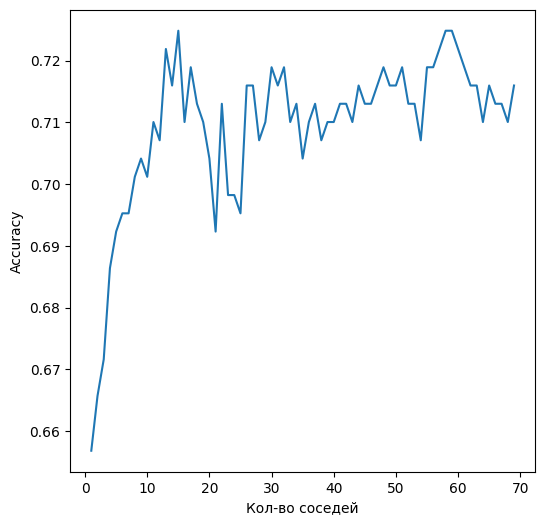

In [364]:
ac = []
for k in range(1,70):
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X_train, Y_train)
  ac.append([k,accuracy_score(Y_test, clf.predict(X_test))])
plt.figure(figsize=(6,6))
plt.plot(range(1,70), [i[1] for i in ac])
plt.xlabel('Кол-во соседей')
plt.ylabel('Accuracy')
plt.show()
k = max(ac, key=lambda x: x[1])[0]

Оптимальное кол-во соседей k поэтому:

In [365]:
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=15)

Считаем метрики, и тп.

In [366]:
y_pred_test = clf.predict(X_test)
print(accuracy_score(Y_test, y_pred_test), 'Accuracy')
print(precision_score(Y_test, y_pred_test), 'Prescision score')
print(recall_score(Y_test, y_pred_test), 'Recall')
print(f1_score(Y_test, y_pred_test), 'F1')

0.7248520710059172 Accuracy
0.7032967032967034 Prescision score
0.49230769230769234 Recall
0.579185520361991 F1


Следовательно у KNeighborsClassifier больше F1 = (0.579185520361991 ), чем у LogisticRegression F2 = (0.5288461538461539  )